In [81]:
import os
import torch
import torch.nn as nn
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
from itertools import product

from sklearn.model_selection import KFold

from datetime import datetime
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torchvision import transforms, utils
from pymongo import MongoClient
import pymongo
import matplotlib

import torch.nn.functional as F
import torch.optim as optim

from torch.utils.tensorboard import SummaryWriter

import torchvision.transforms.functional as TF

import random
import pickle

from PIL import Image

from matplotlib import colors

In [2]:
class LoadMRIDataSet(Dataset):
    '''
    Load our MRI images saved in the MongoDB.
    '''
    
    def __init__(self, db_link = "localhost:27017", db_name = "aswin_image_segmentation", db_col = "training_data", transform=None):
        self.client = MongoClient(db_link)
        self.db = self.client[db_name]
        self.collection = self.db[db_col]
        self.metadata_csv = pd.read_csv('image_name_info_apr_20.csv') # .sample(frac = 1).reset_index(drop=True)
        self.transform = transform
    
    def __len__(self):
        return self.metadata_csv.count()[0]
    
    def __getitem__(self, idx):

        query_val = self.metadata_csv.iloc[idx, 0]
        data_from_db = self.collection.find_one({"img_name" : query_val})
        data = {
            "image" : np.array(data_from_db['image']),
            "label" : np.array(data_from_db['label'])
        }
        
        if self.transform:
            data = self.transform(data)
        
        data['image'] = Image.fromarray(np.uint8(data['image']*255))
        
        data['label'] = Image.fromarray(np.uint8(data['label']))
        
        # Random horizontal flipping
        if random.random() > 0.5:
            data['image'] = TF.hflip(data['image'])
            data['label'] = TF.hflip(data['label'])

        # Random vertical flipping
        if random.random() > 0.5:
            data['image'] = TF.vflip(data['image'])
            data['label'] = TF.vflip(data['label'])
            
        # Random vertical flipping
        if random.random() > 0.5:
            data['image'] = TF.rotate(data['image'], 90)
            data['label'] = TF.rotate(data['label'], 90)
        
        data['image'] = TF.to_tensor(data['image'])
        data['label'] = torch.from_numpy(np.array(data['label']))
#         data['label'] = data['label'].view(data['label'].shape[1], data['label'].shape[2])
        
#         print(data['label'].max())
#         return data['image'], data['label']
        return data

In [3]:
class Normalize_Image(object):
    '''
    Normalize images across each sequence and slice.
    That is, image (HxWxc) -> Normalization happens for each channel.
    '''

    def __call__(self, data):
        image, label = data['image'], data['label']
        
        min_val = image.min((0,1))
        max_val = image.max((0,1))
        
        image = (image - min_val)/(max_val - min_val)
        
#         print(min_val, max_val)
        
        return {'image': image,
                'label': label}

In [4]:
class Standardize_Image(object):
    '''
    Normalize images across each sequence and slice.
    That is, image (HxWxc) -> Normalization happens for each channel.
    '''

    def __call__(self, data):
        image, label = data['image'], data['label']
        
        mean = image.mean((0,1))
        std = image.std((0,1))
        
        if (std != 0).all():
            image = (image - mean)/std
        
#         print(min_val, max_val)
        
        return {'image': image,
                'label': label}

In [5]:
dataset = LoadMRIDataSet(transform=transforms.Compose([Normalize_Image()]))

In [6]:
sample = dataset[2000]

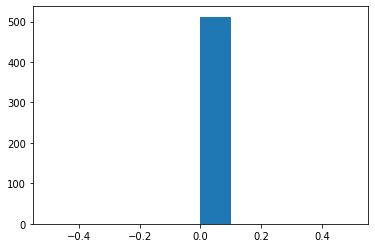

In [7]:
plt.hist(np.array(sample['image'][:,:,0]).ravel())
plt.show()

In [8]:
sample['label'].shape

torch.Size([128, 128])

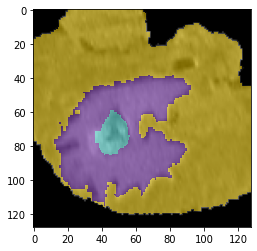

Zero Percent:  0.1988677978515625


In [9]:
for i in range(1):
    sample = dataset[2000]
    
    colors = ['none','gold', 'indigo', 'lightseagreen']
    cmap = matplotlib.colors.ListedColormap(colors)
    plt.imshow(np.array(sample['image'])[0, :,:].T, cmap='gray')
    plt.imshow(np.array(sample['label']).T, alpha=0.5, cmap=cmap)
    plt.show()

    print("Zero Percent: ", np.count_nonzero(np.array(sample['image']) == 0)/np.array(sample['image']).size)

In [10]:
sample['label'].sum()

tensor(17829)

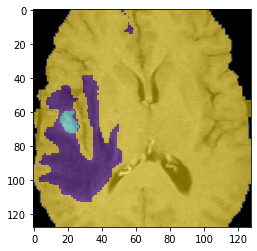

Zero Percent:  0.0968017578125


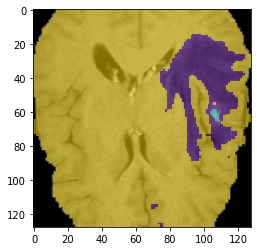

Zero Percent:  0.0977935791015625


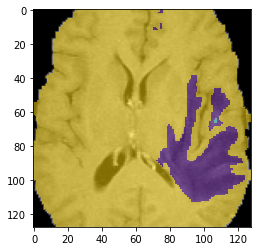

Zero Percent:  0.097747802734375


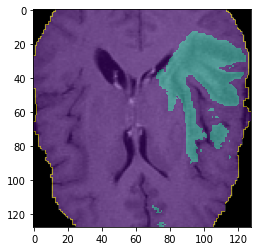

Zero Percent:  0.098846435546875


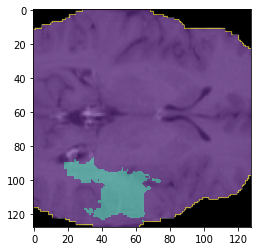

Zero Percent:  0.10809326171875


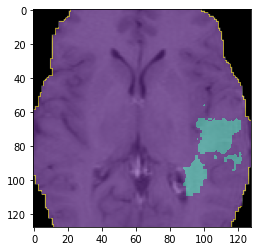

Zero Percent:  0.10614013671875


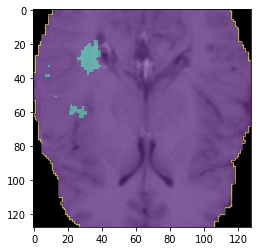

Zero Percent:  0.10345458984375


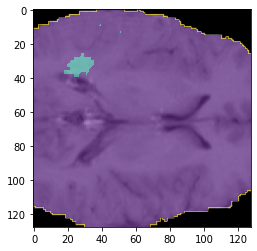

Zero Percent:  0.1025390625


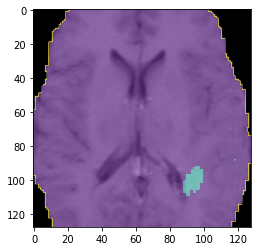

Zero Percent:  0.099609375


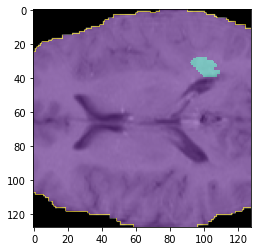

Zero Percent:  0.09906005859375


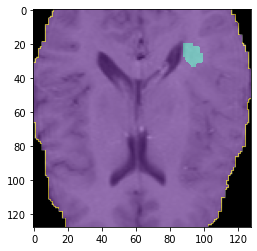

Zero Percent:  0.09771728515625


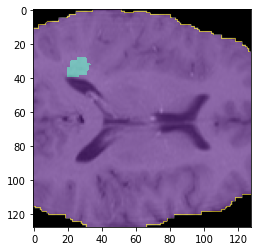

Zero Percent:  0.0977783203125


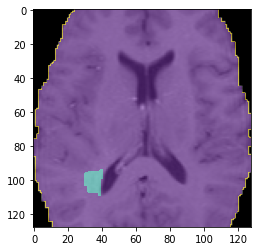

Zero Percent:  0.09954833984375


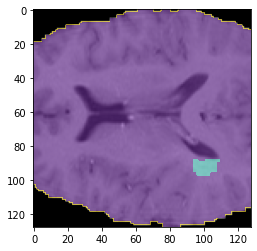

Zero Percent:  0.09967041015625


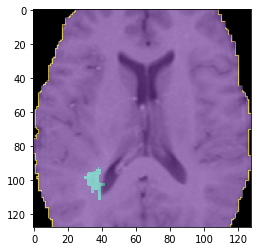

Zero Percent:  0.10040283203125


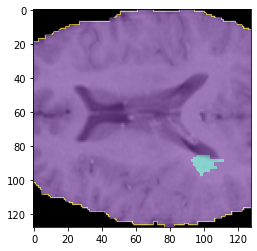

Zero Percent:  0.10089111328125


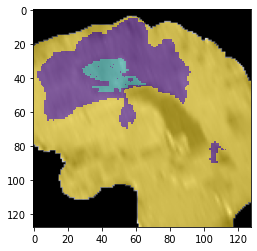

Zero Percent:  0.2193603515625


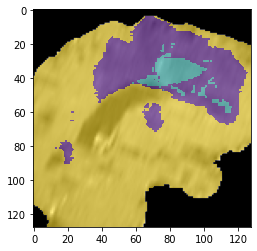

Zero Percent:  0.22015380859375


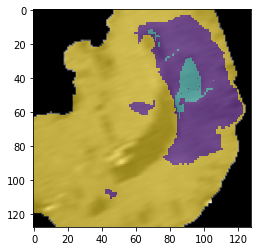

Zero Percent:  0.219482421875


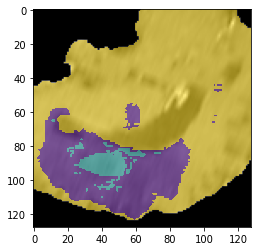

Zero Percent:  0.2220458984375


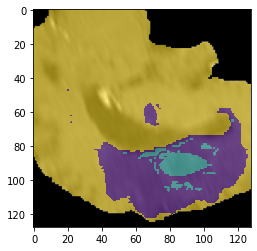

Zero Percent:  0.21966552734375


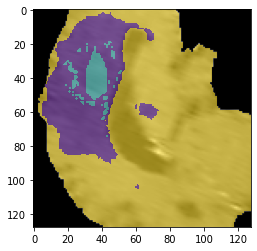

Zero Percent:  0.21759033203125


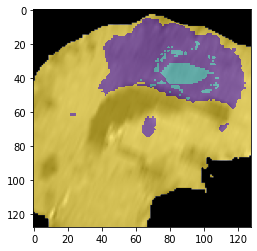

Zero Percent:  0.2222900390625


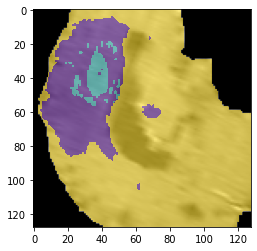

Zero Percent:  0.22052001953125


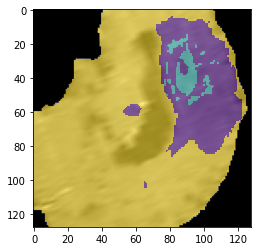

Zero Percent:  0.217041015625


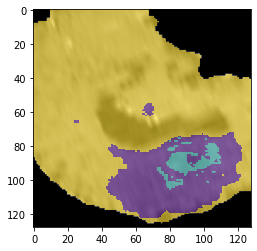

Zero Percent:  0.21514892578125


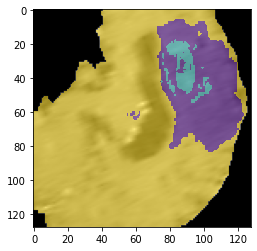

Zero Percent:  0.2137451171875


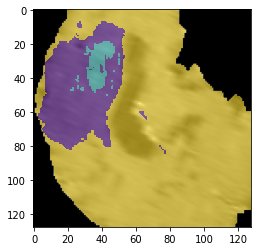

Zero Percent:  0.21112060546875


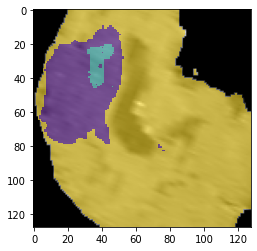

Zero Percent:  0.2120361328125


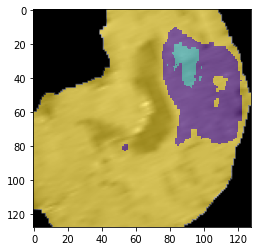

Zero Percent:  0.2080078125


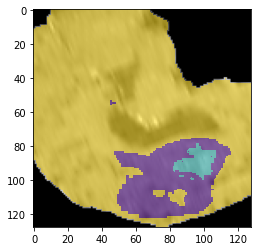

Zero Percent:  0.207275390625


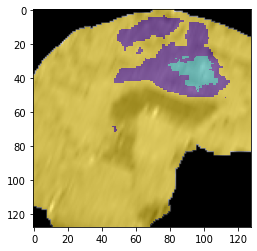

Zero Percent:  0.2032470703125


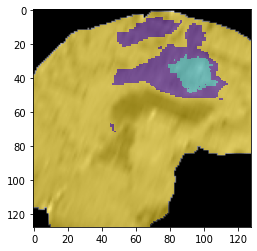

Zero Percent:  0.2091064453125


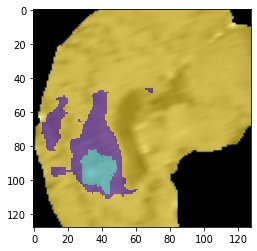

Zero Percent:  0.209716796875


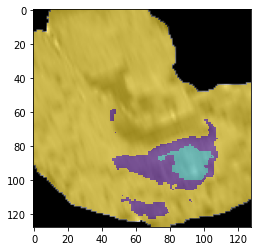

Zero Percent:  0.20745849609375


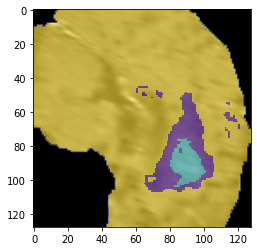

Zero Percent:  0.2086181640625


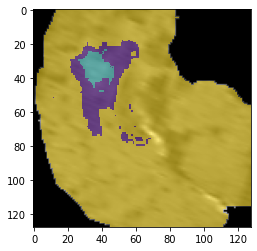

Zero Percent:  0.21136474609375


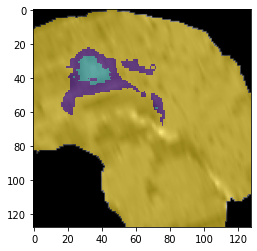

Zero Percent:  0.21038818359375


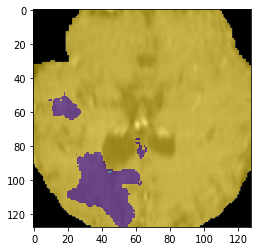

Zero Percent:  0.11517333984375


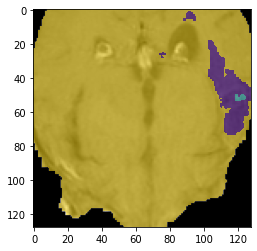

Zero Percent:  0.12933349609375


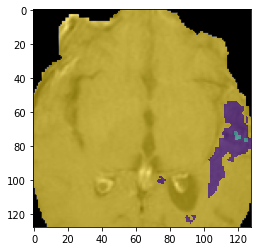

Zero Percent:  0.11871337890625


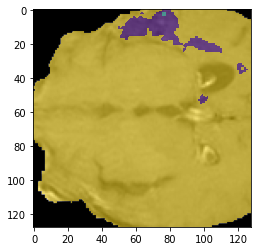

Zero Percent:  0.11407470703125


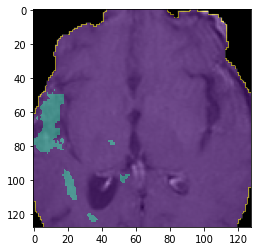

Zero Percent:  0.102783203125


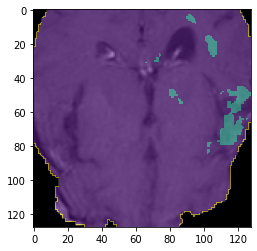

Zero Percent:  0.09783935546875


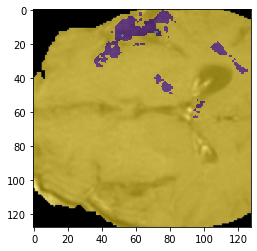

Zero Percent:  0.089599609375


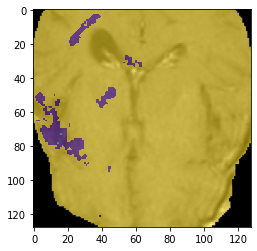

Zero Percent:  0.08477783203125


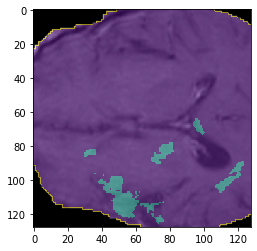

Zero Percent:  0.08062744140625


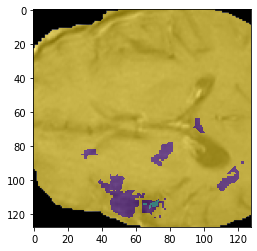

Zero Percent:  0.07867431640625


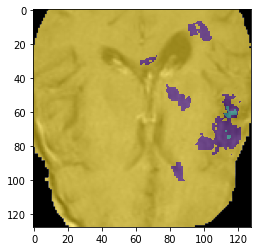

Zero Percent:  0.07537841796875


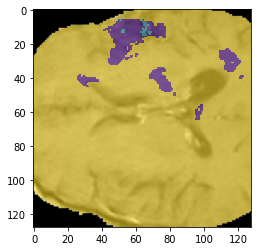

Zero Percent:  0.073486328125


In [11]:
for i in range(500,550):
    sample = dataset[i]
    
    colors = ['none','gold', 'indigo', 'lightseagreen']
    cmap = matplotlib.colors.ListedColormap(colors)
    plt.imshow(np.array(sample['image'])[2,:,:].T, cmap='gray')
    plt.imshow(np.array(sample['label']).T, alpha=0.5, cmap=cmap)
    plt.show()

    print("Zero Percent: ", np.count_nonzero(np.array(sample['image']) == 0)/np.array(sample['image']).size)

In [12]:
# count_list = list()
# for i in range(5329):
#     sample = dataset[i]
    
#     count_list.append([(sample['label']==0).sum(), 
#                        (sample['label']==1).sum(), 
#                        (sample['label']==2).sum(),
#                        (sample['label']==3).sum(),
#                        (sample['label']==4).sum()])

In [13]:
# count_df = pd.DataFrame(count_list)

In [14]:
# count_df.mean().sum()/count_df.mean()

In [15]:
dataloader = DataLoader(dataset, batch_size=4,
                        shuffle=True, num_workers=0)

0 torch.Size([4, 4, 128, 128]) torch.Size([4, 128, 128])


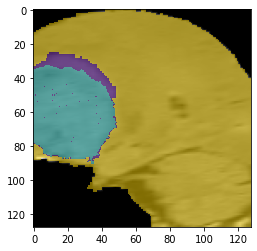

In [16]:
for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['label'].size())

    if i_batch == 0:
        colors = ['none','gold', 'indigo', 'lightseagreen']
        cmap = matplotlib.colors.ListedColormap(colors)
        plt.imshow(sample_batched['image'][i_batch//8, 0, :, :].T, cmap='gray')
        plt.imshow(sample_batched['label'][i_batch//8, :, :].T, alpha=0.5, cmap=cmap)
        #plt.show()
        break

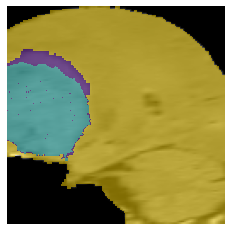

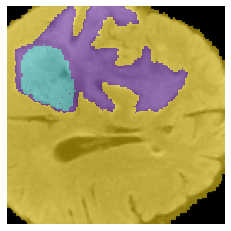

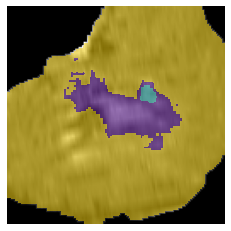

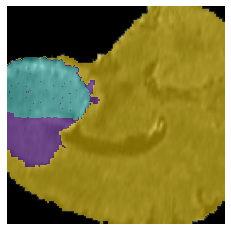

In [17]:
for z in range(sample_batched['image'].shape[0]):
    colors = ['none','gold', 'indigo', 'lightseagreen']
    cmap = matplotlib.colors.ListedColormap(colors)
        
    plt.imshow(sample_batched['image'][z, 0,:,:].T, cmap='gray')
    plt.imshow(sample_batched['label'][z,:,:].T, alpha=0.5, cmap=cmap)
    plt.axis('off')
    plt.show()

## Model Building

# Depth of network = 4

In [7]:
def cont_conv_block(in_channel, out_channel):
    return nn.Sequential(
        nn.Conv2d(in_channel, out_channel, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channel, out_channel, 3, padding=1),
        nn.ReLU(inplace=True)
                        )

def cont_conv(in_channel, path_depth):
    contractive_layers = nn.ModuleList()
    contractive_layers.append(cont_conv_block(in_channel, 64))
    contractive_layers.append(nn.MaxPool2d(2, stride=2))
    in_channel = 64
    for i in range(1, path_depth):
        contractive_layers.append(cont_conv_block((2**(i-1))*in_channel, (2**(i))*in_channel))
        contractive_layers.append(nn.MaxPool2d(2, stride=2))
        
    return contractive_layers[:-1]

def exp_conv(path_depth):
    expansive_layers = nn.ModuleList()
    in_channel = 256
    for i in range(1, path_depth):
#         print(in_channel, i, int(2**-(i-1)*in_channel), int(2**-(i)*in_channel))
        expansive_layers.append(nn.ConvTranspose2d(int(2**-(i-1)*in_channel), int(2**-(i)*in_channel), 2, 2))
        expansive_layers.append(cont_conv_block(int(2**-(i-1)*in_channel), int(2**-(i)*in_channel)))
        
    return expansive_layers

class MRI_UNet(nn.Module):
    def __init__(self):
        super(MRI_UNet, self).__init__()
        self.cont_path = cont_conv(4,3)
        self.exp_path = exp_conv(3)
        self.last_layer = nn.Conv2d(64, 5, 1) # 5 output layers instead of 4
                                              # This is because I differentiated 
                                              # the background and the brain without any tumour
        
    def forward(self, inp_image):
        # Contractive path / down path
#         print('inp: ',inp_image.shape)
        d1 = self.cont_path[0](inp_image)
#         print('d1: ',d1.shape)
        dm1 = self.cont_path[1](d1)
#         print('dm1: ',dm1.shape)
        d2 = self.cont_path[2](dm1)
#         print('d2: ',d2.shape)
        dm2 = self.cont_path[3](d2)
#         print('dm2: ',dm2.shape)
        d3 = self.cont_path[4](dm2)
#         print(d2.shape)

        # Expansive path / up path
        u1 = self.exp_path[0](d3)
#         print('u1: ',u1.shape)
#         u1 = self.exp_path[1](torch.cat([cropped_feature(d2, u1), u1], 1))
        u1 = self.exp_path[1](torch.cat([d2, u1], 1))
#         print('u1_after_cat: ',u1.shape)
        u2 = self.exp_path[2](u1)
#         print('u2: ',u2.shape)
#         u2 = self.exp_path[3](torch.cat([cropped_feature(d1, u2), u2], 1))
        u2 = self.exp_path[3](torch.cat([d1, u2], 1))
#         print('u2_after_cat: ',u2.shape)

        # Last layer with 1x1 convolution
        out = self.last_layer(u2)
        
        return out        
        

In [19]:
model = MRI_UNet()

In [20]:
print(model)

MRI_UNet(
  (cont_path): ModuleList(
    (0): Sequential(
      (0): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
  )
  (exp_path): ModuleList(
    (0): ConvTranspose2d(256, 128, k

# Training

In [21]:
# 0     7.040963
# 1     1.367844
# 2    12.478294
# 3    45.135336
# 4    40.647573
# class weight percent

In [23]:
class IoULoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(IoULoss, self).__init__()
        self.weights = weight

    def forward(self, inputs, targets, eps=0.001):

        inputs = torch.argmax(F.log_softmax(inputs, dim=1), dim=1)
        
        inputs = F.one_hot(inputs, 5).float()
        targets = F.one_hot(targets.long(), 5).float()
        
        bat_sz = inputs.shape[0]
        ch_sz = inputs.shape[3]
        
        intersection = (inputs.view(bat_sz,-1,ch_sz) * targets.view(bat_sz,-1,ch_sz)).sum(1)
#         print("intersection: ",intersection)

        total = (inputs.view(bat_sz,-1,ch_sz) + targets.view(bat_sz,-1,ch_sz)).sum(1)
#         print(total)

        union = total - intersection
#         print(union)

        IoU = (intersection + eps)/(union + eps)
#         print(IoU)

        iouLoss = 1 - (IoU.mean(0) * self.weights).sum()/self.weights.sum()

        return iouLoss, IoU.mean(0)

In [24]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None):
        super(DiceLoss, self).__init__()
        self.weights = weight

    def forward(self, inputs, targets, eps=0.001):
        
        inputs = torch.argmax(F.log_softmax(inputs, dim=1), dim=1)
        
        inputs = F.one_hot(inputs, 5).float()
        targets = F.one_hot(targets, 5).float()
        
        bat_sz = inputs.shape[0]
        ch_sz = inputs.shape[3]

        intersection = (inputs.view(bat_sz,-1,ch_sz) * targets.view(bat_sz,-1,ch_sz)).sum(1)
#         print("intersection: ",intersection)

        total = (inputs.view(bat_sz,-1,ch_sz) + targets.view(bat_sz,-1,ch_sz)).sum(1)
#         print(total)

        dice = (2 * intersection + eps)/(total + eps)
#         print(IoU)

        diceLoss = 1 - (dice.mean(0) * self.weights).sum()/self.weights.sum()

        return diceLoss, dice.mean(0)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = "cpu"

client = MongoClient("localhost:27017") # Initialize the mongodb client - No argument means default localhost connection
db = client["aswin_image_segmentation"] # Name of the DB
results = db["validation_data_results"]

foldwise_results = list()
EPOCHS = 25
N_SPLITS = 5
LAMBDA_REG = 0 # 10e-2
BATCH_SIZE = 16
LEARNING_RATE = 0.001
L2_WEIGHT_DECAY = 0 # 10e-4
OPTIMIZER = 'adam'

channel_list = ['Empty Space', 'Brain Background', 'Edema', 'Non-Enhancing Tumor', 'Enhancing Tumor']

loss_weights = torch.FloatTensor([0.1, 0.1, 0.5, 0.5, 0.5]).to(device)
# loss_weights = torch.FloatTensor([1,1,1,1,1]).to(device)

seg_loss = nn.CrossEntropyLoss(weight=loss_weights).to(device)
iou_loss = IoULoss(weight=loss_weights).to(device)
dice_loss = DiceLoss(weight=loss_weights).to(device)

data_name = pd.read_csv('image_name_info.csv')

nfold = KFold(n_splits=N_SPLITS, shuffle=True)

now = datetime.now()
logdir = "tf_logs/" + now.strftime("%Y%m%d-%H%M%S")

writer = SummaryWriter(logdir)

dataset = LoadMRIDataSet(transform=transforms.Compose([Normalize_Image()]))

model = MRI_UNet().to(device)
#     model.train()
writer.add_graph(model, dataset[7]['image'].view(1,4,128,128).to(device))

for fold, (train_ids, test_ids) in enumerate(nfold.split(data_name)):
#     log_dict = dict()

    print("Fold: ", fold+1, "/", N_SPLITS) #, train_ids.shape, test_ids.shape)

    train_subsampler = SubsetRandomSampler(train_ids)
    test_subsampler = SubsetRandomSampler(test_ids)

    trainloader = DataLoader(
                      dataset, 
                      batch_size=BATCH_SIZE, sampler=train_subsampler)

    testloader = DataLoader(
                      dataset,
                      batch_size=1, sampler=test_subsampler)

    model = MRI_UNet().to(device)
#     model.train()
#     writer.add_graph(model, dataset[7]['image'].view(1,4,128,128).to(device))
    # model.apply(initialize_weights)
    # model = Manual_Classifier().to(device).double()
    print("Model: ", model)

    if OPTIMIZER == "sgd":
        optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, weight_decay=L2_WEIGHT_DECAY) # weight decay is for L2 regularization
    elif OPTIMIZER == "adam":
        optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=L2_WEIGHT_DECAY) # weight decay is for L2 regularization
    elif OPTIMIZER == "rmsprop":
        optimizer = optim.RMSprop(model.parameters(), lr=LEARNING_RATE, weight_decay=L2_WEIGHT_DECAY)

    # scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=2, threshold=0.001)
    # scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

    step = 0
    for epoch in range(EPOCHS):

        print("Epoch: ",epoch+1,"/",EPOCHS)
        current_loss = 0.0
        for i, data in enumerate(trainloader, 0):
#             print(i)

            inputs, labels = data['image'], data['label']
            
            inputs = inputs.to(device)
            labels = labels.float().to(device)

#             print(inputs)
#             print(labels)

            # forward pass
            outputs = model(inputs.float()).to(device)
        
            # loss calculation
            lossCE = seg_loss(outputs.float(), labels.long())

            lossIoU, IoU_per_ch = iou_loss(outputs.float(), labels.long())
            
            diceLoss, dice_per_ch = dice_loss(outputs.clone().float(), labels.clone().long())

            loss = lossCE

            # l1 Regularization

#             l1_reg = nn.L1Loss()
#             for param in model.parameters():
#                 l1_loss += l1_reg(param)

#             l1_loss = sum(param.abs().sum() for param in model.parameters())

#             loss += LAMBDA_REG * l1_loss.to(device)

#             writer.add_scalar("Total Loss/train - Fold: "+str(fold+1), loss.item(), step)
            writer.add_scalar("CE Loss/train - Fold: "+str(fold+1), lossCE.item(), step)
            
            writer.add_scalar("IoU Loss/train - Fold: "+str(fold+1), lossIoU.item(), step)
#             writer.add_scalar("IoU/train - EmptySpace - Fold: "+str(fold+1), IoU_per_ch[0].item(), step)
            writer.add_scalar("IoU/train - Brain_Background - Fold: "+str(fold+1), IoU_per_ch[1].item(), step)
            writer.add_scalar("IoU/train - edema - Fold: "+str(fold+1), IoU_per_ch[2].item(), step)
            writer.add_scalar("IoU/train - NET - Fold: "+str(fold+1), IoU_per_ch[3].item(), step)
            writer.add_scalar("IoU/train - ET - Fold: "+str(fold+1), IoU_per_ch[4].item(), step)
            
            writer.add_scalar("Dice Loss/train - Fold: "+str(fold+1), diceLoss.item(), step)
#             writer.add_scalar("Dice/train - EmptySpace - Fold: "+str(fold+1), dice_per_ch[0].item(), step)
            writer.add_scalar("Dice/train - Brain_Background - Fold: "+str(fold+1), dice_per_ch[1].item(), step)
            writer.add_scalar("Dice/train - edema - Fold: "+str(fold+1), dice_per_ch[2].item(), step)
            writer.add_scalar("Dice/train - NET - Fold: "+str(fold+1), dice_per_ch[3].item(), step)
            writer.add_scalar("Dice/train - ET - Fold: "+str(fold+1), dice_per_ch[4].item(), step)
            step+=1

            optimizer.zero_grad()

            # compute gradients
            loss.backward()
            # update parameters/weights
            optimizer.step()
            # scheduler.step()

            current_loss += loss.item()

            print_tresh = 10
            if i % print_tresh == print_tresh-1:
                print('Loss after mini-batch %5d: %.4f' %
                      (i + 1, current_loss / print_tresh))
                current_loss = 0.0

    print('Finished Training fold: {}'.format(fold+1))

    save_path = f'models/U-net-fold-{fold+1}.pth'
    torch.save(model, save_path)

    for j, test_data in enumerate(testloader, 0):
        
        log_dict = dict()

        test_inputs, test_labels = test_data['image'], test_data['label']

        test_inputs = test_inputs.to(device)
        test_labels = test_labels.to(device)

        predictions = model(test_inputs.float()).to(device)

        test_lossCE = seg_loss(predictions.float(), test_labels.long())
        test_lossIoU, test_IoU_per_ch = iou_loss(predictions.float(), test_labels.long())
        test_lossDice, test_Dice_per_ch = dice_loss(predictions.float(), test_labels.long())
        test_loss = test_lossCE + test_lossIoU + test_lossDice

        hparams = {
            "Num Epochs": EPOCHS,
            "Learning Rate": LEARNING_RATE,
            "L1 Reg Lambda": LAMBDA_REG,
            "L2 Reg Weight Decay": L2_WEIGHT_DECAY,
            "Batch_size" : BATCH_SIZE,
            "Optimizer_name" : OPTIMIZER.upper(),
            "hparams/Kth-Fold" : str(fold+1) + "/" + str(N_SPLITS),
            "Model" : str(model),
            "Index" : j,
            "Predicted Output" : pickle.dumps(predictions),
            "Actual Output" : pickle.dumps(test_labels),
        }

        metric = {
            "train_size" : train_ids.shape[0],
            "test_size" : test_ids.shape[0],
            "test_loss_CE" : test_lossCE.item(),
            "test_loss_IoU" : test_lossIoU.item(),
            "test_loss_Dice" : test_lossDice.item(),
            "test_loss_total" : test_loss.item()
        }
        
        metric.update({
                "IoU Channel " + channel_list[o] : test_IoU_per_ch[o].item()  for o in range(5)
            })
        
        metric.update({
                "Dice Channel " + channel_list[o] :  test_Dice_per_ch[o].item() for o in range(5)
            })

        log_dict.update(hparams)
        log_dict.update(metric)
        
        results.insert_one(log_dict)

#     foldwise_results.append(log_dict)

#     writer.add_hparams(hparams, metric)

writer.flush()
writer.close()

Fold:  1 / 5
Model:  MRI_UNet(
  (cont_path): ModuleList(
    (0): Sequential(
      (0): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
  )
  (exp_path): ModuleList(
    (0): ConvTr